In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import utils
import dataloaders
import torchvision
from trainer import Trainer
torch.random.manual_seed(0)
np.random.seed(0)

### Dataset

In [2]:
# Load the dataset and print some stats
batch_size = 64

image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.5], [0.5])])

dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)
example_images, _ = next(iter(dataloader_train))
print(f"The tensor containing the images has shape: {example_images.shape} (batch size, number of color channels, height, width)",
      f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}", sep="\n\t")

The tensor containing the images has shape: torch.Size([64, 1, 32, 32]) (batch size, number of color channels, height, width)
	The maximum value in the image is 1.0, minimum: -1.0


In [3]:
def create_model():
    """
        Initializes the mode. Edit the code below if you would like to change the model.
    """
    
    #Adding the modell as seen in the assignment:
    model = nn.Sequential(
        nn.Conv2d(1, 32, 5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(32, 64, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(64, 128, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, stride=2),
        nn.Flatten(),  # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
        nn.Linear(2048, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    )
    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model


model = create_model()

In [4]:
# Test if the model is able to do a single forward pass
example_images = utils.to_cuda(example_images)
output = model(example_images)
print("Output shape:", output.shape)
expected_shape = (batch_size, 10) # 10 since mnist has 10 different classes
assert output.shape == expected_shape,    f"Expected shape: {expected_shape}, but got: {output.shape}"

Output shape: torch.Size([64, 10])


### Hyperparameters & Loss function

In [5]:
# Hyperparameters
learning_rate = .02
num_epochs = 5


# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

# Define optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate)

### Train model

In [6]:
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)
train_loss_dict, test_loss_dict = trainer.train(num_epochs)

final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)

print("---- Training model with Adam ----")

learning_rate = .001
optimizer = torch.optim.Adam(model.parameters(),
                            lr=learning_rate)
trainer = Trainer(
  model=model,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer
)

train_loss_adam, test_loss_adam = trainer.train(num_epochs)

final_loss_Adam, final_acc_Adam = utils.compute_loss_and_accuracy(
    dataloader_test, model, loss_function)

Training epoch 0:   1%|          | 5/937 [00:00<00:20, 46.05it/s]

---- Training model with Adam ----


Training epoch 4: 100%|██████████| 937/937 [00:11<00:00, 81.38it/s]


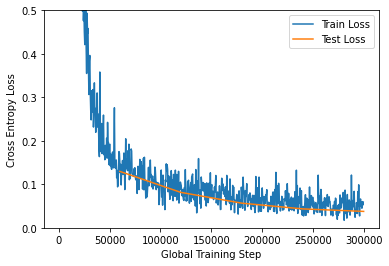

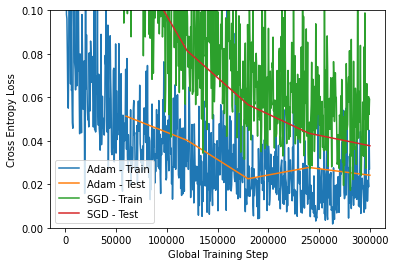

Final Test loss SGD: 0.03773414854821897. Final Test accuracy SGD: 0.9872
Final Test loss Adam: 0.024180289728922322. Final Test accuracy Adam: 0.9918


In [7]:
# We can now plot the training loss with our utility script

# Plot loss
utils.plot_loss(train_loss_dict, label="Train Loss")
utils.plot_loss(test_loss_dict, label="Test Loss")
# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, .5])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig(utils.image_output_dir.joinpath("task2a_plot.png"))
plt.show()

# Plotting both graphs for 2b
plt.ylim([0, .1])
utils.plot_loss(train_loss_adam, label="Adam - Train")
utils.plot_loss(test_loss_adam, label="Adam - Test")
utils.plot_loss(train_loss_dict, label="SGD - Train")
utils.plot_loss(test_loss_dict, label="SGD - Test")
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
plt.savefig(utils.image_output_dir.joinpath("task2b_plot.png"))
plt.show()


print(f"Final Test loss SGD: {final_loss}. Final Test accuracy SGD: {final_acc}")
print(f"Final Test loss Adam: {final_loss_Adam}. Final Test accuracy Adam: {final_acc_Adam}")